<a href="https://colab.research.google.com/github/realover82/AINFT-Lab/blob/master/catdog_220615_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd

/root


In [ ]:
cd ..

/


In [ ]:
cd content/drive/MyDrive/deeplearning/catdog/

/content/drive/MyDrive/deeplearning/catdog


In [ ]:
# 1. Import all the packages that you will need.
import os
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
%%time

for zipf in ['test1', 'train']:
    with zipfile.ZipFile(f"{zipf}.zip","r") as zf:
        zf.extractall(".")
        print(f"{zipf} extracted")

os.listdir('train')[:3]

test1 extracted
train extracted
CPU times: user 28.3 s, sys: 9.34 s, total: 37.7 s
Wall time: 18min 47s


,image,label
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


(Rows, columns): (25000, 2)


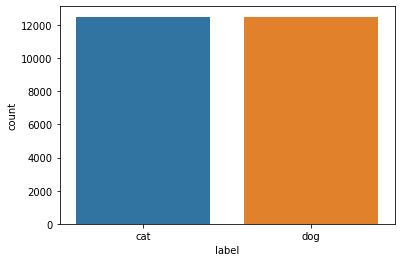

In [ ]:
img_lbl = []
for i in os.listdir('train'):
    if i.split('.')[0] == 'cat':
        img_lbl.append('cat')
    else:
        img_lbl.append('dog')

df = pd.DataFrame({
    'image': os.listdir('train'),
    'label': img_lbl
})
display(df.head())
sns.countplot(data = df, x = 'label');
print('(Rows, columns):', df.shape)

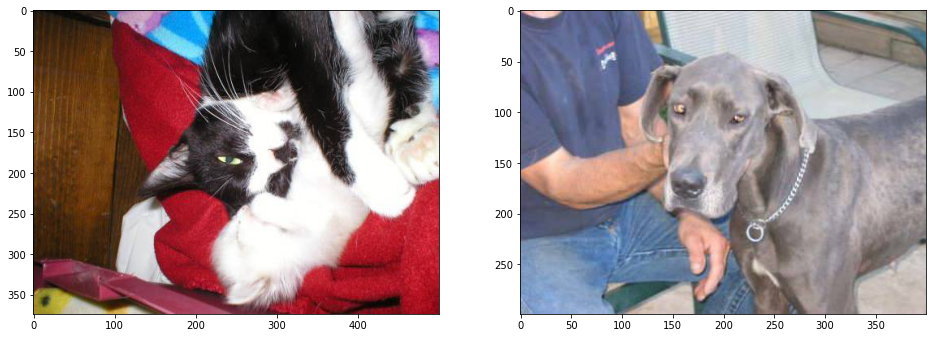

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (16, 9))
img1 = mpimg.imread('train/cat.580.jpg')
img2 = mpimg.imread('train/dog.2303.jpg')
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()

In [ ]:
train, test_valid = train_test_split(df, test_size=0.2, stratify=df['label'])

test, valid = train_test_split(test_valid, test_size=0.5,  stratify=test_valid['label'])
print(f'Train size: {train.shape}')
print(f'Test size: {test.shape}')
print(f'Validation size: {valid.shape}')

Train size: (20000, 2)
Test size: (2500, 2)
Validation size: (2500, 2)


In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

model = models.Sequential()

# convolutional layer 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# flatten output of conv
model.add(layers.Flatten())

# hidden layer
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.2))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [ ]:
model.compile(optimizer = optimizers.Adam(learning_rate=5e-4), loss='binary_crossentropy', metrics='acc')

In [ ]:
aug_gen = ImageDataGenerator(rescale=1./255, shear_range = 0.2, zoom_range = 0.2,
                               rotation_range=40, width_shift_range=0.2,
                               height_shift_range=0.2, horizontal_flip=True, fill_mode='nearest')

train_data = aug_gen.flow_from_dataframe(train, directory='train',
                                           x_col='image', y_col='label', class_mode='binary', target_size=(224,224))

valid_data = aug_gen.flow_from_dataframe(valid, directory='train',
                                       x_col='image', y_col='label', class_mode='binary', target_size=(224,224))
history = model.fit(train_data, validation_data = valid_data, epochs=2,
                   callbacks=[EarlyStopping(monitor='val_acc', min_delta=0.001, patience=5, verbose=1)])

Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Epoch 1/2
625/625 [==============================] - 2080s 3s/step - loss: 0.7599 - acc: 0.5033 - val_loss: 0.6929 - val_acc: 0.5396
Epoch 2/2
625/625 [==============================] - 2058s 3s/step - loss: 0.6751 - acc: 0.5803 - val_loss: 0.6444 - val_acc: 0.6396


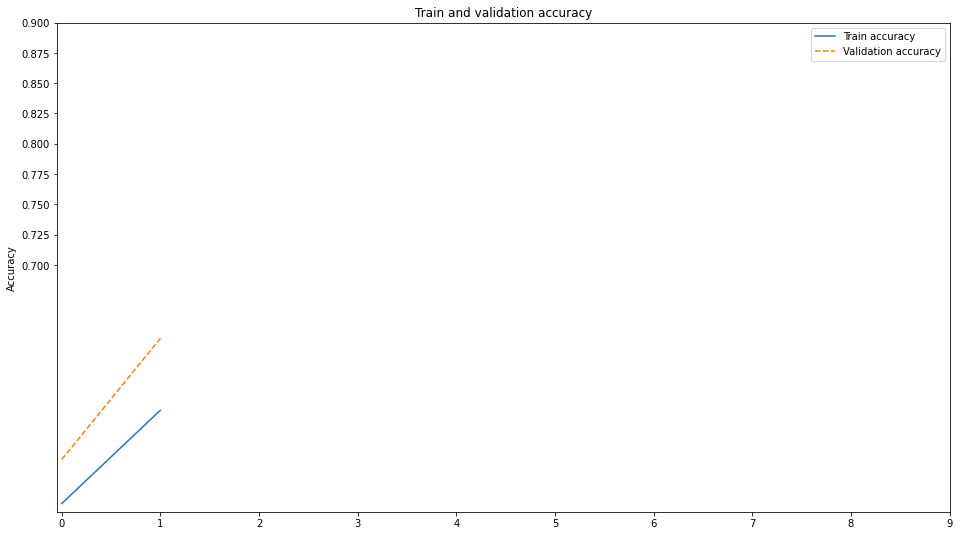

In [ ]:
acc = history.history['acc']
valid_acc = history.history['val_acc']
plt.figure(figsize = (16, 9))
plt.plot(acc, label = 'Train accuracy')
plt.plot(valid_acc, '--', label = 'Validation accuracy')
plt.legend()
plt.xticks(range(10))
plt.yticks(np.arange(0.7, 0.9, 0.025))
plt.ylabel('Accuracy')
plt.title('Train and validation accuracy')
plt.show()

In [ ]:
model.save('model/model_cats_vs_gods.h5')

val_gen = ImageDataGenerator(rescale=1./255)

test_data = val_gen.flow_from_dataframe(test, directory = 'train', x_col = 'image',
                                        y_col = 'label', class_mode = 'binary',
                                        target_size = (224,224), shuffle = False)

test_pred = model.predict(test_data)

Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
def conf_matrix(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    conf_mat_df = pd.DataFrame(data = {'Predicted Positive': [tp, fp], 'Predicted Negative': [fn, tn]}, index = ['Real Positive', 'Real Negative'])
    return conf_mat_df

pred_lbl = test_pred > .5
true_lbl = test_data.classes
display(conf_matrix(true_lbl, pred_lbl))
print(classification_report(true_lbl, pred_lbl))

,Predicted Positive,Predicted Negative
Real Positive,1050,200
Real Negative,693,557


              precision    recall  f1-score   support

           0       0.74      0.45      0.56      1250
           1       0.60      0.84      0.70      1250

    accuracy                           0.64      2500
   macro avg       0.67      0.64      0.63      2500
weighted avg       0.67      0.64      0.63      2500



In [ ]:
model.evaluate(test_data)

79/79 [==============================] - 67s 840ms/step - loss: 0.6440 - acc: 0.6428


[0.6439770460128784, 0.642799973487854]